In [1]:
import sys

In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [3]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [4]:
param_names = [ 'd1','e0' ,'e1','f0', 'g0','g1']

FIXED = {
         'f1':0.12,
         'd0':2.4,
        }

In [5]:
from os.path import exists
params = {}


ndim = len(param_names)
for box in cosmo_params:
    if('Box5_1400' in box): #something weird going on
        continue
    #check if there is a fit for this box by checking if the corresponding figure exsits
    fig_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, 1.0)
    if(not exists(fig_fname)):
        print('Skipping %s'%(box))
        continue
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    params[box] = dict(zip(param_names, final_param_vals))

Skipping Box12_1400
Skipping Box15_1400
Skipping Box21_1400
Skipping Box22_1400
Skipping Box35_1400
Skipping Box36_1400
Skipping Box47_1400
Skipping Box49_1400
Skipping Box52_1400
Skipping Box54_1400
Skipping Box63_1400
Skipping Box70_1400
Skipping Box82_1400
Skipping Box85_1400
Skipping Box95_1400


In [6]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=n_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=X_train.shape[1]), num_tasks=n_tasks, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [8]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_and_aux.pkl", "rb") as f:
    training_idx,testing_idx,μ,rot_matrix,inv_rot_matrix,model,likelihood = pickle.load(f)

In [9]:
X, Y = [], []
for box in params:
    X += [list(cosmo_params[box].values())]
    Y += [list(params[box].values())]
X = np.array(X)
Y = np.array(Y)

X_train, X_test = X[training_idx], X[testing_idx]
X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()

Y_train, Y_test = Y[training_idx], Y[testing_idx]

box_train = np.array(list(params.keys()))[training_idx]
box_test = np.array(list(params.keys()))[testing_idx]

In [10]:
from utils import *
from massfunction import *

In [11]:
import random 

box = sys.argv[1]
box =random.choice(box_test)

mass_function = MassFunction(cosmo_params[box])

In [26]:
if(box not in box_train and box not in box_test):
    assert(1==0)

In [12]:
# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test))
    samples = predictions.sample(torch.Size([1000])).numpy()
    samples = (np.tensordot(inv_rot_matrix,samples.T, axes=1)).T+μ
    mean = predictions.mean.numpy()
    mean = ((inv_rot_matrix@mean.T).T+μ)

mean = dict(zip(box_test, mean))
samples = dict(zip(box_test, np.transpose(samples, axes=[1,0,2])))


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_train))
    samples_train = predictions.sample(torch.Size([1000])) .numpy()
    samples_train = (np.tensordot(inv_rot_matrix,samples_train.T, axes=1)).T+μ

    mean_train = predictions.mean.numpy()
    mean_train = ((inv_rot_matrix@mean_train.T).T+μ)

mean_train = dict(zip(box_train, mean_train))
samples_train = dict(zip(box_train, np.transpose(samples_train, axes=[1,0,2])))

mean = mean | mean_train
samples = samples | samples_train

/oak/stanford/orgs/kipac/users/delon/miniconda3/envs/massfunction/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [13]:
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(NvMs.keys()):        
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

  0%|          | 0/16 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/home/users/delon/aemulusnu_massfunction/utils.py:60: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and ca

In [14]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

In [15]:
a_list = list(NvMs.keys())

In [18]:
from multiprocessing import Pool

def estimate_uncertainty(param_combo):
    c_params = dict(zip(param_names, param_combo)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    return tinker_eval_MCMC

pred_data = {}

for a in tqdm(N_data):
    pred_data[a] = {}
    Pk = mass_function.Pka[a]
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]
    edges = np.array(edges)

    pred_data[a]['Ms, N, Edges'] = (Ms, N, edges)


    #get uncertainty in emulator prediction
    pool = Pool()
    uncertainty_estimate = list(tqdm(pool.imap(estimate_uncertainty, samples[box]), 
                                     total=len(samples[box])))    
    emulator_uncertainty = np.std(uncertainty_estimate, axis=0)
    uncertainty_estimate_res = np.array([(result-N) / N for result in uncertainty_estimate])
    pred_data[a]['emulataor_sampled_NvM'] = uncertainty_estimate
    pred_data[a]['emulataor_sampled_residual'] = uncertainty_estimate_res
    
    #Emulator 
    c_params = dict(zip(param_names, mean[box])) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, 
                                      edge[0],  
                                      edge[1], 
                                      epsabs=1e-1)[0] for edge in edge_pairs])
    
    pred_data[a]['emulataor_mean_NvM'] = tinker_eval_MCMC
    pred_data[a]['emulataor_mean_residual'] = (tinker_eval_MCMC-N)/N

    #ML Fit
    params = None
    if(box in box_test):
        params = Y_test[np.where(box_test==box)][0]
    elif(box in box_train):
        params = Y_train[np.where(box_train==box)][0]

    c_params = dict(zip(param_names, params)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, 
                                      edge[0],  
                                      edge[1], 
                                      epsabs=1e-1)[0] for edge in edge_pairs])

    pred_data[a]['MLFit_NvM'] = tinker_eval_MCMC
    pred_data[a]['MLFit_residual'] = tinker_eval_MCMC
    pred_data[a]['train/test'] = 'test' if box in box_test else 'train'

100%|██████████| 16/16 [00:36<00:00,  2.26s/it]


In [19]:
with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/emu_pred_for_%s.pkl"%(box), "wb") as f:
    pickle.dump(pred_data, f)


In [ ]:
for key in pred_data[1.0]:
    print(key)

  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_14849/1068269815.py:67: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
  6%|▋         | 1/16 [00:13<03:28, 13.91s/it]/tmp/ipykernel_14849/1068269815.py:67: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
 12%|█▎        | 2/16 [00:26<03:04, 13.21s/it]/tmp/ipykernel_14849/1068269815.py:67: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
 19%|█▉        | 3/16 [00:39<02:48, 12.99s/it]/tmp/ipykernel_14849/1068269815.py:67: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhlin

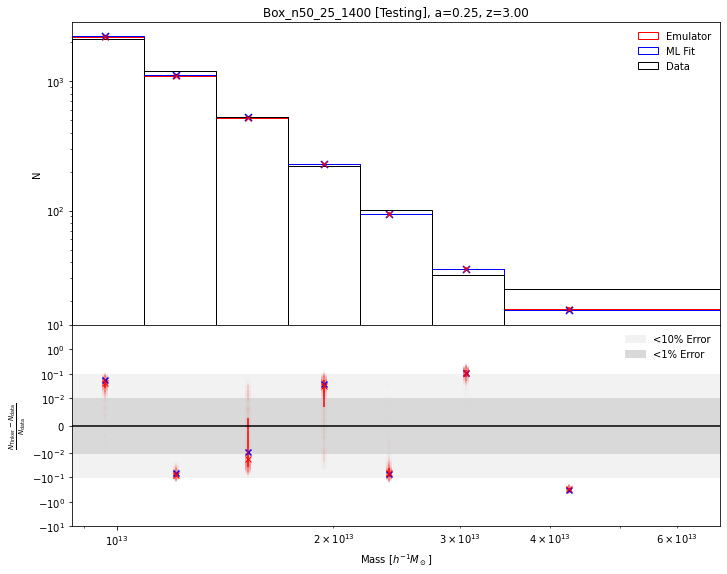

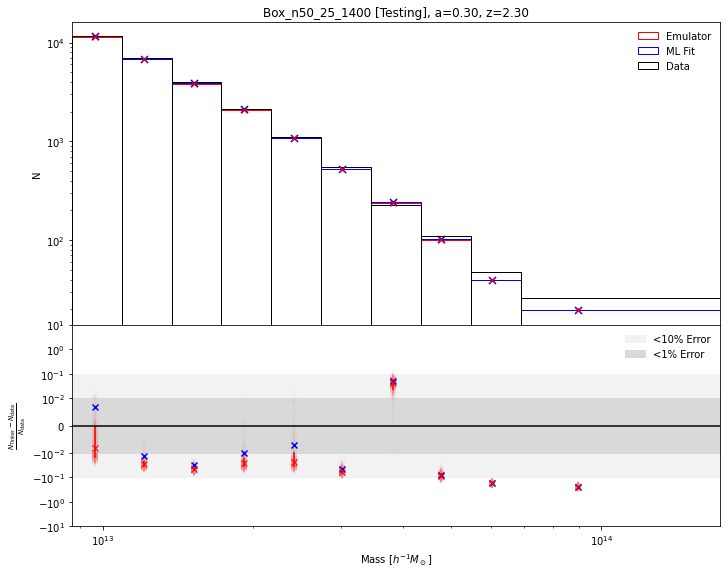

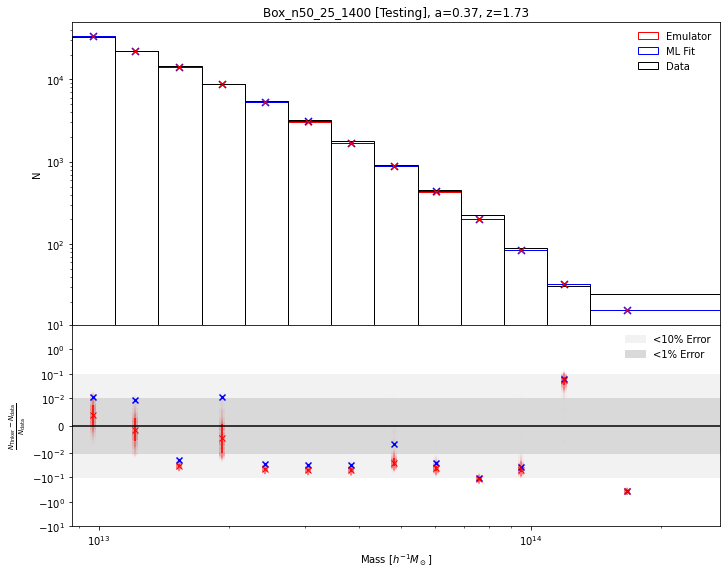

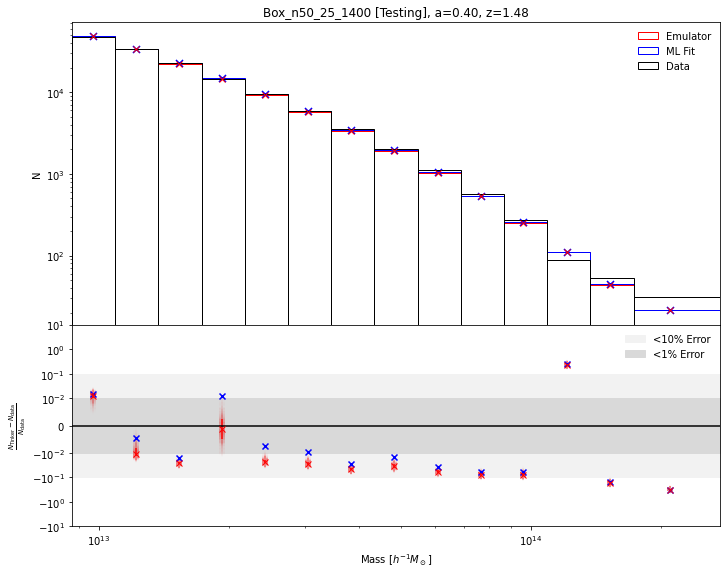

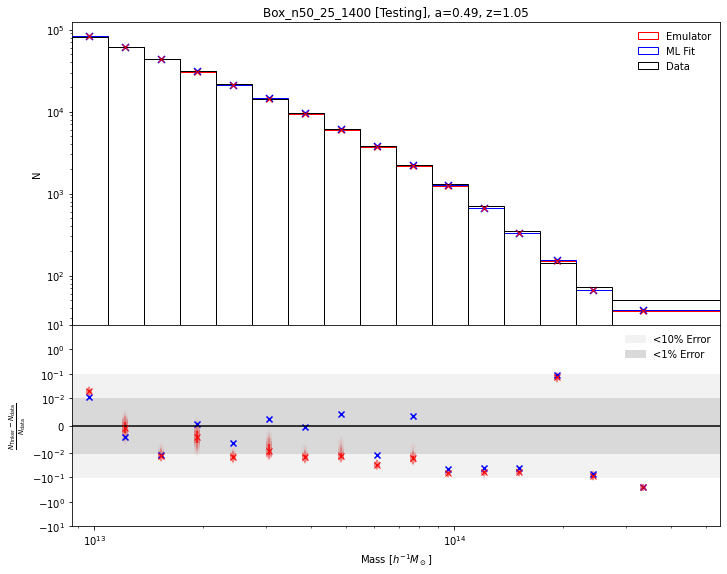

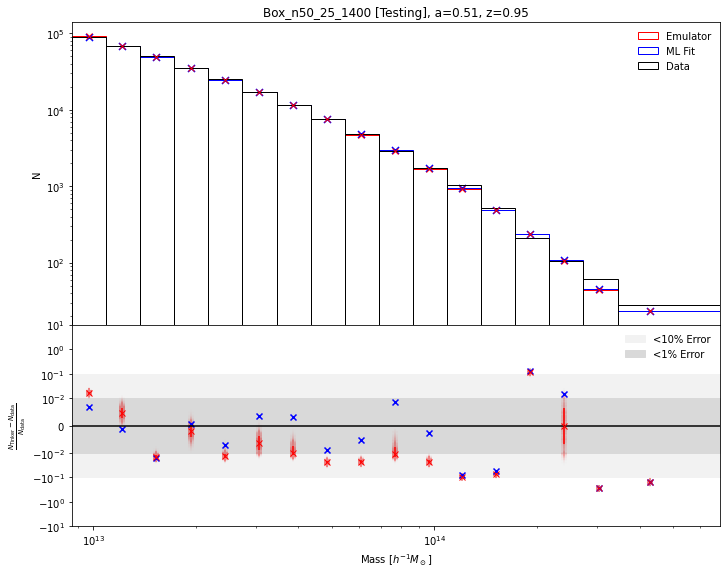

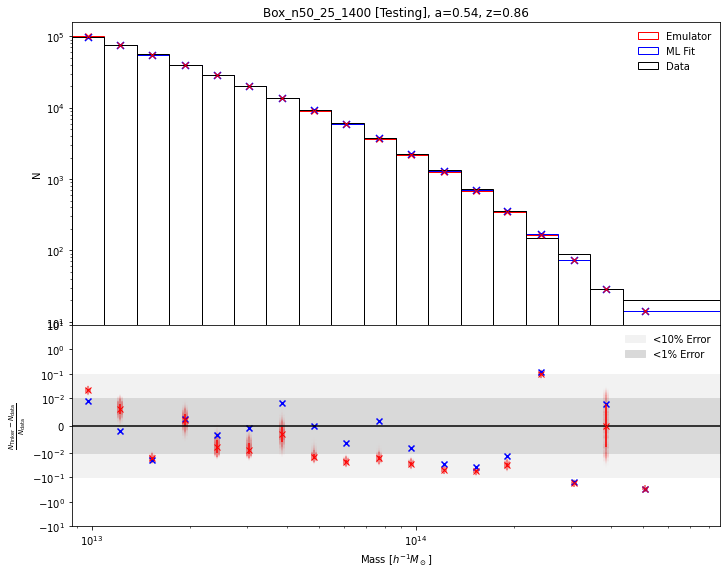

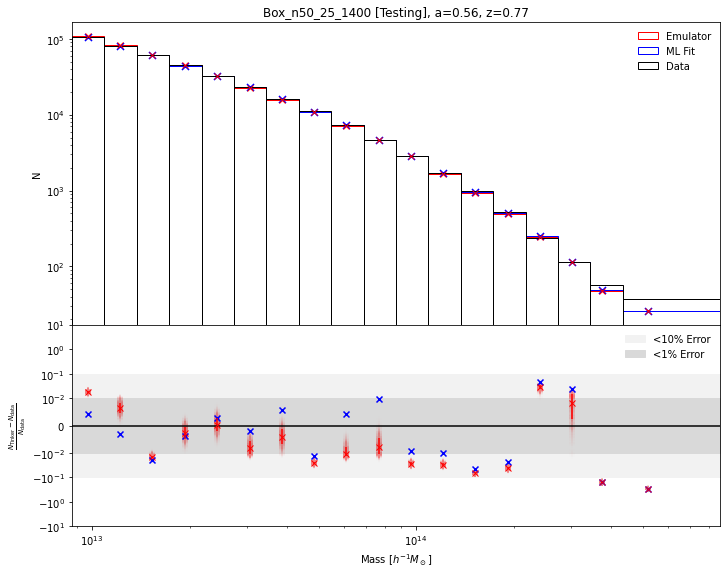

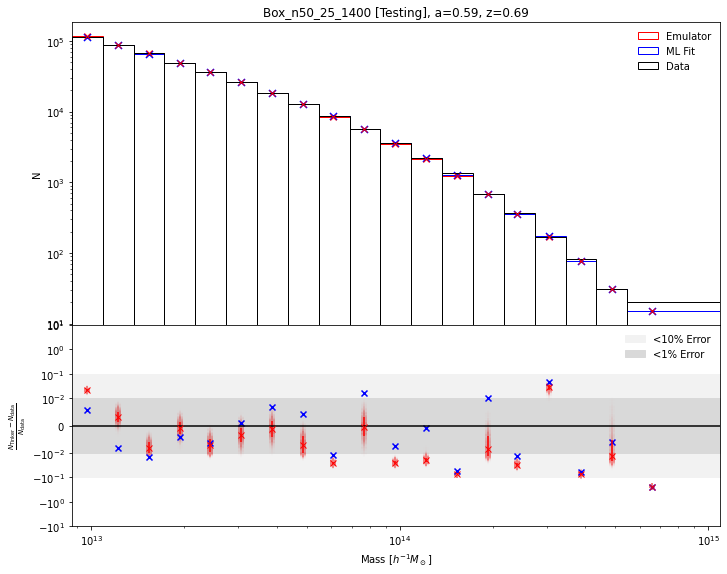

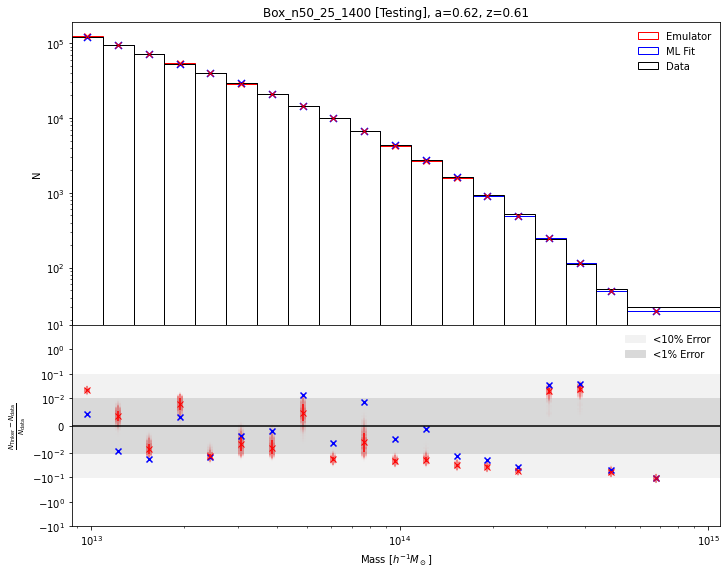

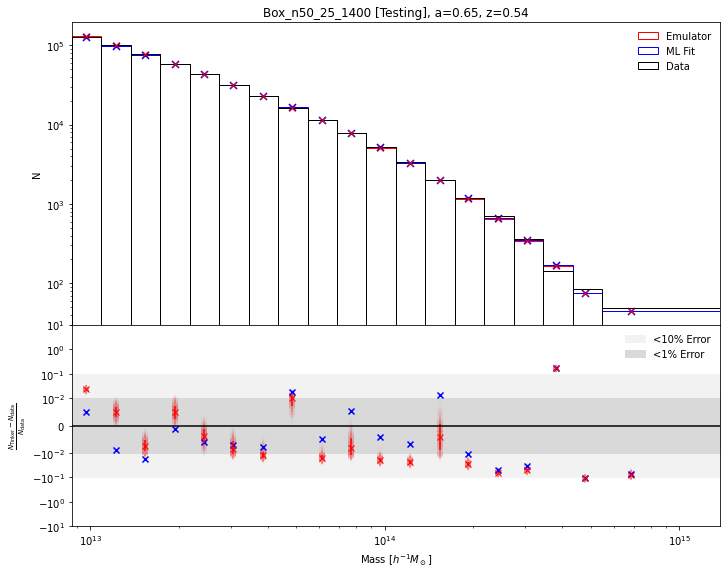

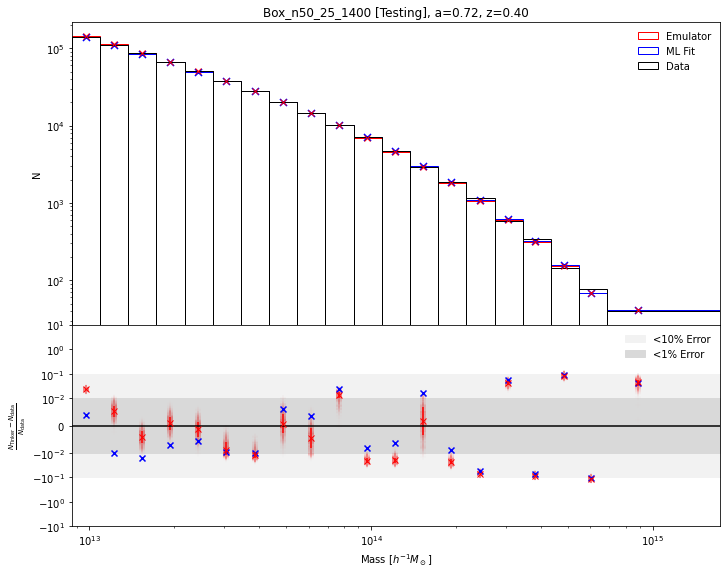

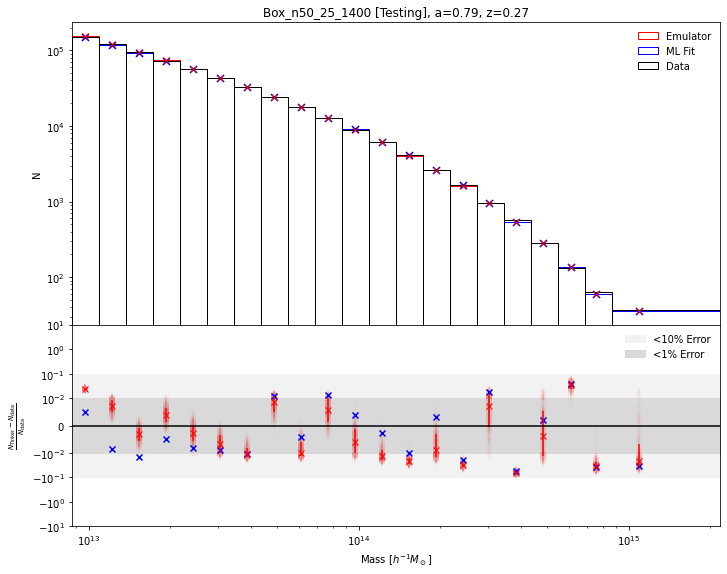

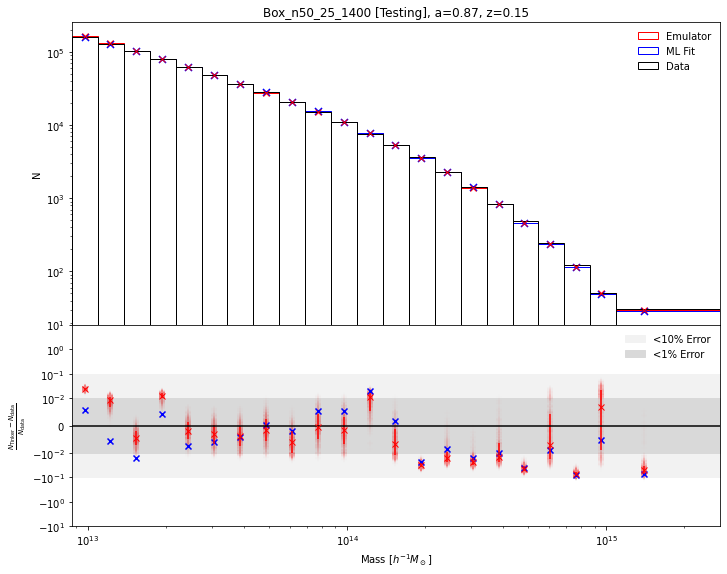

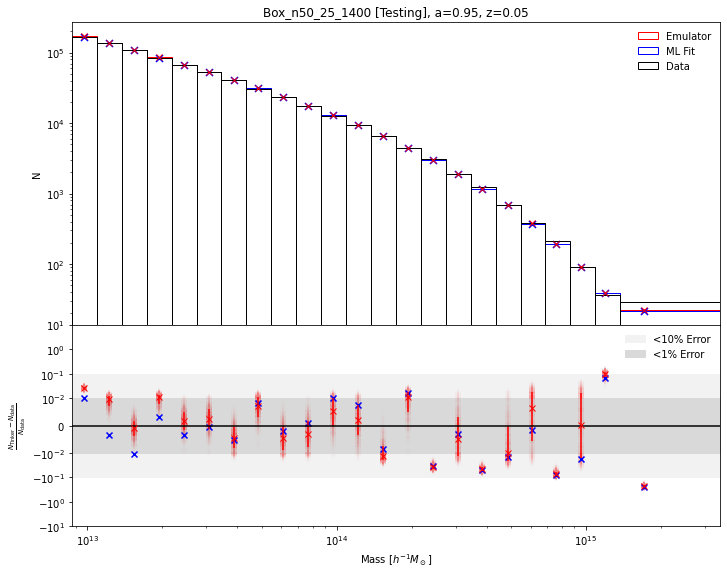

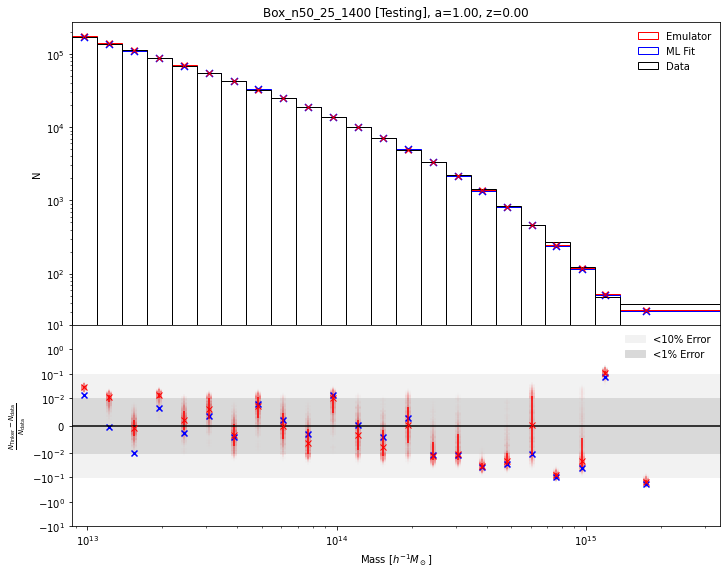

In [27]:

for a in tqdm(N_data):
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = mass_function.Pka[a]
    
    Ms, N, edges = pred_data[a]['Ms, N, Edges']
    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    #get uncertainty in emulator prediction
    pool = Pool()
    uncertainty_estimate = pred_data[a]['emulataor_sampled_NvM']
    emulator_uncertainty = np.std(uncertainty_estimate, axis=0)
    
    for result in uncertainty_estimate:
        axs[1].scatter(Ms, (result-N)/N, color='lightcoral', alpha=0.01, marker='+')


    #Emulator 
    tinker_eval_MCMC = pred_data[a]['emulataor_mean_NvM']
    axs[0].errorbar(Ms, tinker_eval_MCMC, emulator_uncertainty, fmt='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='red', label='Emulator')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, emulator_uncertainty/N, fmt='x', color='red')

    #ML Fit
    tinker_eval_MCMC = pred_data[a]['MLFit_NvM']
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='blue')

    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
    
    status_string = 'Testing'
    if(box in box_train):
        status_string = 'Training'
    axs[0].set_title('%s [%s], a=%.2f, z=%.2f'%(box, status_string, a, scaleToRedshift(a)))

    axs[0].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_ylim((-1e1, 1e1))
    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_%s_emufit_z%.2f.pdf'%(status_string,box, scaleToRedshift(a)), bbox_inches='tight')